# Méthodes de pénalité et de barrière

In [1]:
using BenchmarkTools
using ForwardDiff

In [2]:
include("btr.jl")

BTRState(903177296, #undef, #undef, #undef, #undef, 0.0, 0.0, 1.0e-6, #undef, false)

## Méthodes de pénalités

## Premier exemple

$$
\min_x f(x) = x_1^2+x_1\sin(x_2)+4x_2^2
$$

In [3]:
f(x) = x[1]^2+x[1]*sin(x[2])+4x[2]^2

f (generic function with 1 method)

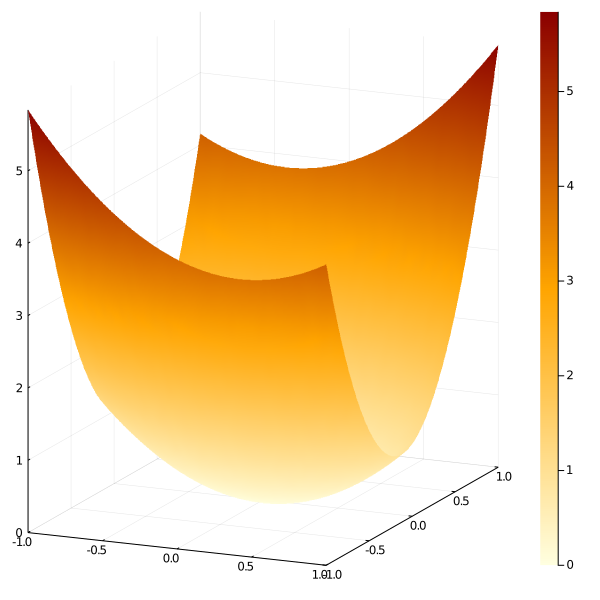

In [4]:
using Plots
#plotly()
gr()

default(size=(600,600), fc=:heat)
x, y = -1.0:0.05:1.0, -1.0:0.05:1.0
z = Surface((x,y)->f([x,y]), x, y)
surface(x,y,z, linealpha = 1)

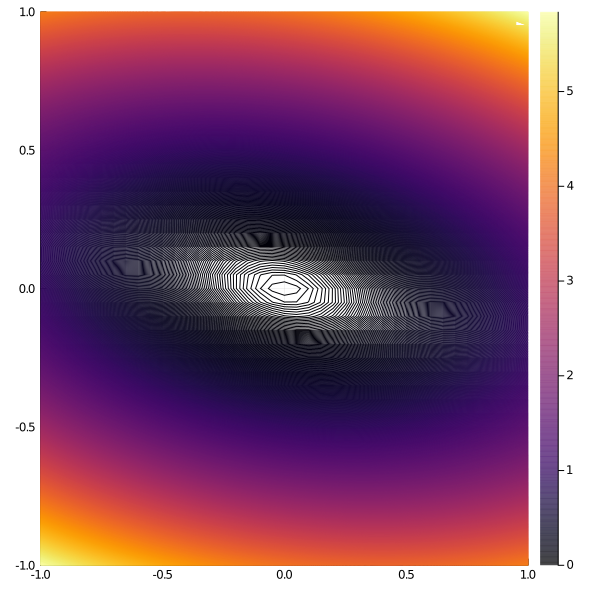

In [5]:
Plots.contour(x,y,z, linealpha = 0.5, levels=1200)

In [6]:
g = x -> ForwardDiff.gradient(f, x);
H = x -> ForwardDiff.hessian(f, x)

function g!(x::Vector, storage::Vector)
    s = g(x)
    storage[1:length(s)] = s[1:length(s)]
end

function H!(x::Vector, storage::Matrix)
    s = H(x)
    n, m = size(s)
    storage[1:n,1:m] = s[1:length(s)]
end

H! (generic function with 1 method)

In [7]:
state = btr(f, g!, H!, TruncatedCG, [1.0,1.0])

0. 0.9000595582133543 [-0.2841470984807897, -0.854030230586814] [2.8414709848078967, 8.54030230586814]
1. 3.6002382328534166 [-0.7153892140789949, -0.14795275986716255] [1.5771577572160769, 1.8759981876154477]
2. 3.6002382328534166 [0.00013018788069688782, 0.001899296248822171] [-0.0010556142739432859, -0.015400237103264795]
3. 3.6002382328534166 [-0.0005938753205307463, 8.369420458674014e-5] [0.0011040564367678796, -7.567832240307031e-5]


BTRState(4, [3.81551669599578e-13, -5.676852488523815e-13], [3.81551669599578e-13, -5.676852488523815e-13], [1.9541809034677449e-13, -4.159930321219474e-12], [-0.0005938753205307463, 8.369420458674014e-5], 3.6002382328534166, 1.00000000052592, 1.0e-6, #undef, false)

In [8]:
state.x

2-element Array{Float64,1}:
  3.81551669599578e-13
 -5.676852488523815e-13

Il est facile de voir que $(0,0)$ est en effet un point critique au premier ordre.

In [9]:
g(state.x)

2-element Array{Float64,1}:
  1.9541809034677449e-13
 -4.159930321219474e-12

Introduisons à présent la contrainte
$$
(x-1)^2+(y-1)^2 = 1
$$

In [10]:
c(x) = (x[1]-1.0)^2+(x[2]-1.0)^2-1.0
gc = x -> ForwardDiff.gradient(c, x);
Hc = x -> ForwardDiff.hessian(c, x)

function gc!(x::Vector, storage::Vector)
    s = gc(x)
    storage[1:length(s)] = s[1:length(s)]
end

function Hc!(x::Vector, storage::Matrix)
    s = Hc(x)
    n, m = size(s)
    storage[1:n,1:m] = s[1:length(s)]
end

Hc! (generic function with 1 method)

In [11]:
μ = 1.0
Φ(x) = f(x)+1/(2*μ)*(c(x)*c(x))

Φ (generic function with 1 method)

In [12]:
gΦ = x -> ForwardDiff.gradient(Φ, x);
HΦ = x -> ForwardDiff.hessian(Φ, x)

function gΦ!(x::Vector, storage::Vector)
    s = gΦ(x)
    storage[1:length(s)] = s[1:length(s)]
end

function HΦ!(x::Vector, storage::Matrix)
    s = HΦ(x)
    n, m = size(s)
    storage[1:n,1:m] = s[1:length(s)]
end

HΦ! (generic function with 1 method)

In [13]:
state = btr(Φ, gΦ!, HΦ!, TruncatedCG, [0.0,0.0])

0. 0.28284271247461906 [0.20689655172413793, 0.06896551724137931] [-2.0, -2.0]
1. 0.872352457977484 [0.059099242764991344, -0.005493062351137588] [-0.3037981473732586, -0.16515622799259633]
2. 0.872352457977484 [0.0034629092916186694, -0.0005936029495485461] [-0.015044016531456483, -0.005662700011239807]
3. 0.872352457977484 [1.0454793855392537e-5, -1.682372723557532e-6] [-4.555437178577204e-5, -1.8337576967453195e-5]


BTRState(4, [0.26946915857460335, 0.06287716956796961], [0.26946915857460335, 0.06287716956796961], [-4.173904555315744e-10, -1.6865153718015335e-10], [1.0454793855392537e-5, -1.682372723557532e-6], 0.872352457977484, 1.0000068623108131, 1.0e-6, #undef, false)

In [14]:
state.x

2-element Array{Float64,1}:
 0.26946915857460335
 0.06287716956796961

In [15]:
f(state.x)

0.10536007698275898

In [16]:
c(state.x)

0.41187450959063776

In [17]:
Φ(state.x)

0.19018038280802316

In [18]:
μ = 0.1
state = btr(Φ, gΦ!, HΦ!, TruncatedCG, [0.0,0.0])

0. 2.8284271247461903 [0.18867924528301885, 0.18867924528301885] [-20.0, -20.0]
1. 2.8284271247461903 [0.1385081135921954, -0.008426199435259817] [-4.570459978724189, -3.440615531154511]
2. 2.8284271247461903 [0.08018571443970317, -0.042021390026853324] [-0.8438290550418325, -0.27991381292958684]
3. 2.8284271247461903 [0.016014738247793148, -0.005940128848281158] [-0.1598387796553541, -0.10822203306398848]
4. 2.8284271247461903 [0.0006840294399178377, -0.00026022778898194193] [-0.006167506262203415, -0.00401874190074758]
5. 2.8284271247461903 [1.1553496317845756e-6, -4.2014763904699193e-7] [-1.0787559046265827e-5, -7.53352890736636e-6]


BTRState(6, [0.4240729963522602, 0.13203087903600358], [0.4240729963522602, 0.13203087903600358], [-3.1314950632577165e-11, -2.1150858842133857e-11], [1.1553496317845756e-6, -4.2014763904699193e-7], 2.8284271247461903, 1.0000380646045615, 1.0e-6, #undef, false)

In [19]:
state.x

2-element Array{Float64,1}:
 0.4240729963522602
 0.13203087903600358

In [20]:
f(state.x)

0.30539471735985

In [21]:
c(state.x)

0.08506230847767604

In [22]:
μ = 0.01
state = btr(Φ, gΦ!, HΦ!, TruncatedCG, [0.0,0.0])

0. 28.284271247461902 [0.19880715705765406, 0.19880715705765406] [-200.0, -200.0]
1. 28.284271247461902 [0.07791248831766392, 0.0758463949196365] [-44.88378699112595, -43.69355294799361]
2. 28.284271247461902 [0.07490719627246886, -0.04867349943830518] [-6.301386056619382, -4.682818399814002]
3. 28.284271247461902 [0.0739098727030808, -0.05583921334582337] [-1.6006438768267586, -0.8673195924114623]
4. 28.284271247461902 [0.02501100617679234, -0.012102900206684017] [-1.1251445960913582, -1.3188876056016057]
5. 28.284271247461902 [0.008359913753985863, -0.004924874310368139] [-0.12811196585318596, -0.109051233357079]
6. 28.284271247461902 [2.8545406161515633e-5, 3.680423267470718e-5] [-0.011683989835585828, -0.015064430264003725]
7. 28.284271247461902 [0.0003209407720896442, -0.00020304518862637733] [-0.0014450618609855859, 0.001119142560098929]
8. 28.284271247461902 [1.1211329115809353e-7, 1.2272353260058883e-8] [-1.5819764005442494e-5, -2.429544747828416e-5]

BTRState(9, [0.4592572325731883, 0.15294683599251147], [0.4592572325731883, 0.15294683599251147], [-4.553246668592692e-12, -2.4917845564687013e-12], [1.1211329115809353e-7, 1.2272353260058883e-8], 28.284271247461902, 1.0001163782742488, 1.0e-6, #undef, false)

In [23]:
c(state.x)

0.009901803179504176

In [24]:
μ = 0.00001
state = btr(Φ, gΦ!, HΦ!, TruncatedCG, [0.0,0.0])

0. 28284.2712474619 [0.1999988000071999, 0.1999988000071999] [-199999.99999999997, -199999.99999999997]
1. 28284.2712474619 [0.07887223790497834, 0.07887012994826655] [-44800.08293153807, -44798.88559470558]
2. 28284.2712474619 [0.013622342303073888, 0.01361845316452184] [-5776.419577318704, -5774.770426565394]
3. 28284.2712474619 [0.0004003181949327127, 0.0003959623711238226] [-160.39857915752887, -158.65329763185667]
4. 28284.2712474619 [0.1313608943788049, -0.1313563797756895] [-1.0042562883372255, 0.7447025263968685]
5. 14142.13562373095 [0.1313608943788049, -0.1313563797756895] [-1.0042562883372255, 0.7447025263968685]
6. 7071.067811865475 [0.1313608943788049, -0.1313563797756895] [-1.0042562883372255, 0.7447025263968685]
7. 3535.5339059327375 [0.1313608943788049, -0.1313563797756895] [-1.0042562883372255, 0.7447025263968685]
8. 1767.7669529663688 [0.1313608943788049, -0.1313563797756895] [-1.0042562883372255, 0.7447025263968685]
9. 883.8834764831844 [0.1313608943788049, -0.131356

BTRState(79, [0.46386744794590323, 0.15586020919861424], [0.46386744794590323, 0.15586020919861424], [-4.858871083257554e-10, 3.691602579181108e-10], [2.5389293886986622e-11, 3.9973064265629353e-11], 0.006743495761743044, 1.6089930552575464, 1.0e-6, #undef, false)

In [25]:
c(state.x)

1.0099786245998388e-5

In [26]:
μ = 0.00001
state = btr(Φ, gΦ!, HΦ!, TruncatedCG, [0.0,1.0])

0. 0.8044132856826369 [-3.820591713658898e-5, -0.8044132847753347] [0.8414709848078965, 8.0]
1. 0.40220664284131846 [-0.00011522469384545882, -0.40220662633645626] [0.8414709848078965, 8.0]
2. 0.20110332142065923 [-0.00015373408879820424, -0.2011032626593883] [0.8414709848078965, 8.0]
3. 0.10055166071032962 [-0.00017298879947121783, -0.10055151190549301] [0.8414709848078965, 8.0]
4. 0.05027583035516481 [-0.00018261618120116462, -0.05027549869699628] [0.8414709848078965, 8.0]
5. 0.025137915177582404 [-0.00018742992485428427, -0.025137216423036915] [0.8414709848078965, 8.0]
6. 0.012568957588791202 [0.000501408062152176, -6.8431620448470625e-6] [-200.56541575636012, 2.737294719039328]
7. 0.012568957588791202 [7.22165228090623e-5, -0.01256875012253268] [-0.04468485615996132, 7.77706776080599]
8. 0.006284478794395601 [0.0003236517367144662, -7.007141516023114e-6] [-129.1316883362868, 2.795733536179444]
9. 0.006284478794395601 [-8.460957558046651e-5, -0.006283909208202173] [0.103293056626666

155. 0.012568957588791185 [0.010461719342678033, -0.006966428300346436] [-0.08548859741351977, 0.059838458328406396]
156. 0.006284478794395592 [0.005227791652441034, -0.003487817104705422] [-0.08548859741351977, 0.059838458328406396]
157. 0.003142239397197796 [1.5236760475510705e-5, 2.288067170667514e-5] [-6.095138121098325, -9.15292030611363]
158. 0.003142239397197796 [0.002626139391608017, -0.0017254159861165783] [-0.061161779298189334, 0.040184276614430914]
159. 0.012568957588791185 [3.6066570109849234e-6, 5.26842823506851e-6] [-1.4420005415782582, -2.106403892883713]
160. 0.012568957588791185 [0.009847114573737995, -0.006419059575235705] [-0.04764944915696212, 0.03259019389395568]
161. 0.006284478794395592 [0.005263019203350352, -0.0034344290038335755] [-0.04764944915696212, 0.03259019389395568]
162. 0.003142239397197796 [1.237170591340638e-5, 1.911725352426749e-5] [-4.949140183689243, -7.647608848849234]
163. 0.003142239397197796 [0.0026449121996515368, -0.0016964987136559927] [-0

240. 1.3307901487935127e-24 [7.1349628849473025e-25, 1.1233545595359038e-24] [-1.7501615954262917e-6, -2.7555181993932365e-6]
241. 6.653950743967563e-25 [3.5674814424736512e-25, 5.616772797679519e-25] [-1.7501615954262917e-6, -2.7555181993932365e-6]
242. 3.3269753719837817e-25 [1.7837407212368256e-25, 2.8083863988397595e-25] [-1.7501615954262917e-6, -2.7555181993932365e-6]
243. 1.6634876859918908e-25 [8.918703606184128e-26, 1.4041931994198797e-25] [-1.7501615954262917e-6, -2.7555181993932365e-6]
244. 8.317438429959454e-26 [4.459351803092064e-26, 7.020965997099399e-26] [-1.7501615954262917e-6, -2.7555181993932365e-6]
245. 4.158719214979727e-26 [2.229675901546032e-26, 3.5104829985496993e-26] [-1.7501615954262917e-6, -2.7555181993932365e-6]
246. 2.0793596074898636e-26 [1.114837950773016e-26, 1.7552414992748497e-26] [-1.7501615954262917e-6, -2.7555181993932365e-6]
247. 1.0396798037449318e-26 [5.57418975386508e-27, 8.776207496374248e-27] [-1.7501615954262917e-6, -2.7555181993932365e-6]
248.

324. 6.880023815365954e-50 [3.688689356071142e-50, 5.807606954194659e-50] [-1.7501615954262917e-6, -2.7555181993932365e-6]
325. 3.440011907682977e-50 [1.844344678035571e-50, 2.9038034770973297e-50] [-1.7501615954262917e-6, -2.7555181993932365e-6]
326. 1.7200059538414885e-50 [9.221723390177855e-51, 1.4519017385486648e-50] [-1.7501615954262917e-6, -2.7555181993932365e-6]
327. 8.600029769207443e-51 [4.6108616950889275e-51, 7.259508692743324e-51] [-1.7501615954262917e-6, -2.7555181993932365e-6]
328. 4.3000148846037213e-51 [2.3054308475444637e-51, 3.629754346371662e-51] [-1.7501615954262917e-6, -2.7555181993932365e-6]
329. 2.1500074423018607e-51 [1.1527154237722319e-51, 1.814877173185831e-51] [-1.7501615954262917e-6, -2.7555181993932365e-6]
330. 1.0750037211509303e-51 [5.763577118861159e-52, 9.074385865929155e-52] [-1.7501615954262917e-6, -2.7555181993932365e-6]
331. 5.375018605754652e-52 [2.8817885594305797e-52, 4.5371929329645776e-52] [-1.7501615954262917e-6, -2.7555181993932365e-6]
332. 

408. 3.556888946233643e-75 [1.9070077006704753e-75, 3.002462423648726e-75] [-1.7501615954262917e-6, -2.7555181993932365e-6]
409. 1.7784444731168214e-75 [9.535038503352376e-76, 1.501231211824363e-75] [-1.7501615954262917e-6, -2.7555181993932365e-6]
410. 8.892222365584107e-76 [4.767519251676188e-76, 7.506156059121815e-76] [-1.7501615954262917e-6, -2.7555181993932365e-6]
411. 4.4461111827920535e-76 [2.383759625838094e-76, 3.7530780295609075e-76] [-1.7501615954262917e-6, -2.7555181993932365e-6]
412. 2.2230555913960268e-76 [1.191879812919047e-76, 1.8765390147804538e-76] [-1.7501615954262917e-6, -2.7555181993932365e-6]
413. 1.1115277956980134e-76 [5.959399064595235e-77, 9.382695073902269e-77] [-1.7501615954262917e-6, -2.7555181993932365e-6]
414. 5.557638978490067e-77 [2.9796995322976176e-77, 4.6913475369511344e-77] [-1.7501615954262917e-6, -2.7555181993932365e-6]
415. 2.7788194892450335e-77 [1.4898497661488088e-77, 2.3456737684755672e-77] [-1.7501615954262917e-6, -2.7555181993932365e-6]
416.

491. 3.677736971660797e-100 [1.9717997474799307e-100, 3.1044733834515016e-100] [-1.7501615954262917e-6, -2.7555181993932365e-6]
492. 1.8388684858303986e-100 [9.858998737399654e-101, 1.5522366917257508e-100] [-1.7501615954262917e-6, -2.7555181993932365e-6]
493. 9.194342429151993e-101 [4.929499368699827e-101, 7.761183458628754e-101] [-1.7501615954262917e-6, -2.7555181993932365e-6]
494. 4.5971712145759965e-101 [2.4647496843499134e-101, 3.880591729314377e-101] [-1.7501615954262917e-6, -2.7555181993932365e-6]
495. 2.2985856072879983e-101 [1.2323748421749567e-101, 1.9402958646571885e-101] [-1.7501615954262917e-6, -2.7555181993932365e-6]
496. 1.1492928036439991e-101 [6.1618742108747835e-102, 9.701479323285942e-102] [-1.7501615954262917e-6, -2.7555181993932365e-6]
497. 5.746464018219996e-102 [3.0809371054373918e-102, 4.850739661642971e-102] [-1.7501615954262917e-6, -2.7555181993932365e-6]
498. 2.873232009109998e-102 [1.5404685527186959e-102, 2.4253698308214856e-102] [-1.7501615954262917e-6, -2

573. 7.605381802568238e-125 [4.077586307380886e-125, 6.419900487444959e-125] [-1.7501615954262917e-6, -2.7555181993932365e-6]
574. 3.802690901284119e-125 [2.038793153690443e-125, 3.2099502437224793e-125] [-1.7501615954262917e-6, -2.7555181993932365e-6]
575. 1.9013454506420595e-125 [1.0193965768452215e-125, 1.6049751218612397e-125] [-1.7501615954262917e-6, -2.7555181993932365e-6]
576. 9.506727253210298e-126 [5.0969828842261075e-126, 8.024875609306198e-126] [-1.7501615954262917e-6, -2.7555181993932365e-6]
577. 4.753363626605149e-126 [2.5484914421130537e-126, 4.012437804653099e-126] [-1.7501615954262917e-6, -2.7555181993932365e-6]
578. 2.3766818133025744e-126 [1.2742457210565269e-126, 2.0062189023265496e-126] [-1.7501615954262917e-6, -2.7555181993932365e-6]
579. 1.1883409066512872e-126 [6.371228605282634e-127, 1.0031094511632748e-126] [-1.7501615954262917e-6, -2.7555181993932365e-6]
580. 5.941704533256436e-127 [3.185614302641317e-127, 5.015547255816374e-127] [-1.7501615954262917e-6, -2.75

654. 3.1455121890740225e-149 [1.68645016973858e-149, 2.655208608867101e-149] [-1.7501615954262917e-6, -2.7555181993932365e-6]
655. 1.5727560945370112e-149 [8.4322508486929e-150, 1.3276043044335505e-149] [-1.7501615954262917e-6, -2.7555181993932365e-6]
656. 7.863780472685056e-150 [4.21612542434645e-150, 6.638021522167752e-150] [-1.7501615954262917e-6, -2.7555181993932365e-6]
657. 3.931890236342528e-150 [2.108062712173225e-150, 3.319010761083876e-150] [-1.7501615954262917e-6, -2.7555181993932365e-6]
658. 1.965945118171264e-150 [1.0540313560866125e-150, 1.659505380541938e-150] [-1.7501615954262917e-6, -2.7555181993932365e-6]
659. 9.82972559085632e-151 [5.270156780432746e-151, 8.297526902709192e-151] [-1.7501615954262917e-6, -2.7555181993932365e-6]
660. 4.91486279542816e-151 [2.6350783902170057e-151, 4.148763451355592e-151] [-1.7501615954262917e-6, -2.7555181993932365e-6]
661. 2.45743139771408e-151 [1.317539195109767e-151, 2.0743817256797866e-151] [-1.7501615954262917e-6, -2.75551819939323

849. 6.263862530977948e-208 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
850. 3.131931265488974e-208 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
851. 1.565965632744487e-208 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
852. 7.829828163722434e-209 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
853. 3.914914081861217e-209 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
854. 1.9574570409306086e-209 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
855. 9.787285204653043e-210 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
856. 4.8936426023265215e-210 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
857. 2.4468213011632608e-210 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
858. 1.2234106505816304e-210 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
859. 6.117053252908152e-211 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
860. 3.058526626454076e-211 

965. 7.539850259959781e-243 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
966. 3.7699251299798903e-243 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
967. 1.8849625649899452e-243 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
968. 9.424812824949726e-244 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
969. 4.712406412474863e-244 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
970. 2.3562032062374314e-244 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
971. 1.1781016031187157e-244 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
972. 5.890508015593579e-245 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
973. 2.9452540077967893e-245 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
974. 1.4726270038983947e-245 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
975. 7.363135019491973e-246 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
976. 3.6815675097459866e-2

1081. 9.075764619907766e-278 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1082. 4.537882309953883e-278 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1083. 2.2689411549769416e-278 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1084. 1.1344705774884708e-278 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1085. 5.672352887442354e-279 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1086. 2.836176443721177e-279 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1087. 1.4180882218605885e-279 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1088. 7.090441109302942e-280 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1089. 3.545220554651471e-280 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1090. 1.7726102773257356e-280 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1091. 8.863051386628678e-281 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1092. 4.431525693

1197. 1.092455428104e-312 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1198. 5.4622771405e-313 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1199. 2.7311385703e-313 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1200. 1.36556928514e-313 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1201. 6.8278464257e-314 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1202. 3.413923213e-314 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1203. 1.706961606e-314 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1204. 8.53480803e-315 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1205. 4.267404013e-315 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1206. 2.133702006e-315 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1207. 1.066851003e-315 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1208. 5.33425504e-316 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6

1339. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1340. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1341. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1342. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1343. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1344. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1345. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1346. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1347. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1348. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1349. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1350. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1351. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1352. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1353. 0.0 [0.0, 0.0]

1488. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1489. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1490. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1491. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1492. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1493. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1494. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1495. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1496. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1497. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1498. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1499. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1500. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1501. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1502. 0.0 [0.0, 0.0]

1634. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1635. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1636. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1637. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1638. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1639. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1640. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1641. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1642. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1643. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1644. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1645. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1646. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1647. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1648. 0.0 [0.0, 0.0]

1782. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1783. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1784. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1785. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1786. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1787. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1788. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1789. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1790. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1791. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1792. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1793. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1794. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1795. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1796. 0.0 [0.0, 0.0]

1929. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1930. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1931. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1932. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1933. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1934. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1935. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1936. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1937. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1938. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1939. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1940. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1941. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1942. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
1943. 0.0 [0.0, 0.0]

2077. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2078. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2079. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2080. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2081. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2082. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2083. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2084. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2085. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2086. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2087. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2088. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2089. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2090. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2091. 0.0 [0.0, 0.0]

2227. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2228. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2229. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2230. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2231. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2232. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2233. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2234. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2235. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2236. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2237. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2238. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2239. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2240. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2241. 0.0 [0.0, 0.0]

2384. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2385. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2386. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2387. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2388. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2389. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2390. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2391. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2392. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2393. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2394. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2395. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2396. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2397. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2398. 0.0 [0.0, 0.0]

2532. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2533. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2534. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2535. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2536. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2537. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2538. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2539. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2540. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2541. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2542. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2543. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2544. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2545. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2546. 0.0 [0.0, 0.0]

2680. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2681. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2682. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2683. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2684. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2685. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2686. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2687. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2688. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2689. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2690. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2691. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2692. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2693. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2694. 0.0 [0.0, 0.0]

2827. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2828. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2829. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2830. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2831. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2832. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2833. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2834. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2835. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2836. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2837. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2838. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2839. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2840. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2841. 0.0 [0.0, 0.0]

2975. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2976. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2977. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2978. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2979. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2980. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2981. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2982. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2983. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2984. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2985. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2986. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2987. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2988. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
2989. 0.0 [0.0, 0.0]

3177. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3178. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3179. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3180. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3181. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3182. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3183. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3184. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3185. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3186. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3187. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3188. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3189. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3190. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3191. 0.0 [0.0, 0.0]

3325. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3326. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3327. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3328. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3329. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3330. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3331. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3332. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3333. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3334. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3335. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3336. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3337. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3338. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3339. 0.0 [0.0, 0.0]

3473. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3474. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3475. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3476. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3477. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3478. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3479. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3480. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3481. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3482. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3483. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3484. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3485. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3486. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3487. 0.0 [0.0, 0.0]

3619. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3620. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3621. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3622. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3623. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3624. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3625. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3626. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3627. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3628. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3629. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3630. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3631. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3632. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3633. 0.0 [0.0, 0.0]

3860. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3861. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3862. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3863. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3864. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3865. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3866. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3867. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3868. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3869. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3870. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3871. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3872. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3873. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
3874. 0.0 [0.0, 0.0]

4008. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4009. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4010. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4011. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4012. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4013. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4014. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4015. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4016. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4017. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4018. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4019. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4020. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4021. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4022. 0.0 [0.0, 0.0]

4155. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4156. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4157. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4158. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4159. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4160. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4161. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4162. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4163. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4164. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4165. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4166. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4167. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4168. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4169. 0.0 [0.0, 0.0]

4304. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4305. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4306. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4307. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4308. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4309. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4310. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4311. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4312. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4313. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4314. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4315. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4316. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4317. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4318. 0.0 [0.0, 0.0]

4451. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4452. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4453. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4454. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4455. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4456. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4457. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4458. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4459. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4460. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4461. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4462. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4463. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4464. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4465. 0.0 [0.0, 0.0]

4634. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4635. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4636. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4637. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4638. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4639. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4640. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4641. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4642. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4643. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4644. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4645. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4646. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4647. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4648. 0.0 [0.0, 0.0]

4783. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4784. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4785. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4786. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4787. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4788. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4789. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4790. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4791. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4792. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4793. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4794. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4795. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4796. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4797. 0.0 [0.0, 0.0]

4930. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4931. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4932. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4933. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4934. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4935. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4936. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4937. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4938. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4939. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4940. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4941. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4942. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4943. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
4944. 0.0 [0.0, 0.0]

5076. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5077. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5078. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5079. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5080. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5081. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5082. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5083. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5084. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5085. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5086. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5087. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5088. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5089. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5090. 0.0 [0.0, 0.0]

5240. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5241. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5242. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5243. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5244. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5245. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5246. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5247. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5248. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5249. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5250. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5251. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5252. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5253. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5254. 0.0 [0.0, 0.0]

5388. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5389. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5390. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5391. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5392. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5393. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5394. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5395. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5396. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5397. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5398. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5399. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5400. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5401. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5402. 0.0 [0.0, 0.0]

5536. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5537. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5538. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5539. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5540. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5541. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5542. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5543. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5544. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5545. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5546. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5547. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5548. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5549. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5550. 0.0 [0.0, 0.0]

5684. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5685. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5686. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5687. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5688. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5689. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5690. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5691. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5692. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5693. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5694. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5695. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5696. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5697. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5698. 0.0 [0.0, 0.0]

5832. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5833. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5834. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5835. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5836. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5837. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5838. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5839. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5840. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5841. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5842. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5843. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5844. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5845. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
5846. 0.0 [0.0, 0.0]

6046. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6047. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6048. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6049. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6050. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6051. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6052. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6053. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6054. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6055. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6056. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6057. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6058. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6059. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6060. 0.0 [0.0, 0.0]

6193. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6194. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6195. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6196. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6197. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6198. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6199. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6200. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6201. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6202. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6203. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6204. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6205. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6206. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6207. 0.0 [0.0, 0.0]

6341. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6342. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6343. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6344. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6345. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6346. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6347. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6348. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6349. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6350. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6351. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6352. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6353. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6354. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6355. 0.0 [0.0, 0.0]

6489. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6490. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6491. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6492. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6493. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6494. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6495. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6496. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6497. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6498. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6499. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6500. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6501. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6502. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6503. 0.0 [0.0, 0.0]

6637. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6638. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6639. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6640. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6641. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6642. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6643. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6644. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6645. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6646. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6647. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6648. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6649. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6650. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6651. 0.0 [0.0, 0.0]

Excessive output truncated after 524313 bytes.


6709. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6710. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6711. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6712. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6713. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6714. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6715. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6716. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6717. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6718. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6719. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6720. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6721. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6722. 0.0 [0.0, 0.0] [-1.7501615954262917e-6, -2.7555181993932365e-6]
6723. 0.0 [0.0, 0.0

BTRState(100000, [0.4638674480344358, 0.1558602091327183], [0.4638674480344358, 0.1558602091327183], [-1.7501615954262917e-6, -2.7555181993932365e-6], [0.0, 0.0], 0.0, NaN, 1.0e-6, #undef, false)

In [27]:
f(state.x)

0.38434874399149505

In [28]:
state.x

2-element Array{Float64,1}:
 0.4638674480344358
 0.1558602091327183

In [29]:
μ = 1
α = 0.1
x0 = [0.0,1.0]
state = btr(Φ, gΦ!, HΦ!, TruncatedCG, x0)
println(state.x)
while (μ > 1e-6)
    x0 = state.x
    state = btr(Φ, gΦ!, HΦ!, TruncatedCG, x0)
    println(state.x)
    μ *= α
end

0. 0.8044132856826369 [-0.08414709848078965, -0.7999999999999999] [0.8414709848078965, 8.0]
1. 3.2176531427305477 [0.2704994937188506, -0.11603339173369102] [-1.7375975977146838, 0.21293035132575922]
2. 3.2176531427305477 [0.07768651986838784, -0.020118755842512902] [-0.3589293023011945, -0.060692495543601455]
3. 3.2176531427305477 [0.005404875215895361, -0.0009665939683532606] [-0.023409948880229292, -0.008376087573170432]
4. 3.2176531427305477 [2.5367784427658662e-5, -4.08881247800461e-6] [-0.00011051232149938972, -4.4413900384898675e-5]
[0.26946915810677186, 0.06287716964296489]
[0.26946915810677186, 0.06287716964296489]
0. 0.8809179701777916 [0.07585190950925895, 0.09730260795149681] [-5.415966590017693, -6.947586121382605]
1. 0.8809179701777916 [0.06471698506835566, -0.02215623628413802] [-0.9031252313266953, -0.6267420183602446]
2. 0.8809179701777916 [0.013608034770623301, -0.005845403549621723] [-0.11675934432393986, -0.05947905406581544]
3. 0.8809179701777916 [0.000426423001926

64. 3.153676480232029e-18 [1.690862880502664e-18, 2.6620777714610275e-18] [-4.444671483971874e-6, -6.9976467609311754e-6]
65. 1.5768382401160144e-18 [8.45431440251332e-19, 1.3310388857305138e-18] [-4.444671483971874e-6, -6.9976467609311754e-6]
66. 7.884191200580072e-19 [4.22715720125666e-19, 6.655194428652569e-19] [-4.444671483971874e-6, -6.9976467609311754e-6]
67. 3.942095600290036e-19 [2.11357860062833e-19, 3.3275972143262844e-19] [-4.444671483971874e-6, -6.9976467609311754e-6]
68. 1.971047800145018e-19 [1.056789300314165e-19, 1.6637986071631422e-19] [-4.444671483971874e-6, -6.9976467609311754e-6]
69. 9.85523900072509e-20 [5.283946501570825e-20, 8.318993035815711e-20] [-4.444671483971874e-6, -6.9976467609311754e-6]
70. 4.927619500362545e-20 [2.6419732507854125e-20, 4.1594965179078555e-20] [-4.444671483971874e-6, -6.9976467609311754e-6]
71. 2.4638097501812726e-20 [1.3209866253927063e-20, 2.0797482589539277e-20] [-4.444671483971874e-6, -6.9976467609311754e-6]
72. 1.2319048750906363e-20

148. 1.6304125266952537e-43 [8.741556207733565e-44, 1.3762619510380822e-43] [-4.444671483971874e-6, -6.9976467609311754e-6]
149. 8.152062633476269e-44 [4.3707781038667827e-44, 6.881309755190411e-44] [-4.444671483971874e-6, -6.9976467609311754e-6]
150. 4.0760313167381343e-44 [2.1853890519333913e-44, 3.4406548775952056e-44] [-4.444671483971874e-6, -6.9976467609311754e-6]
151. 2.0380156583690671e-44 [1.0926945259666957e-44, 1.7203274387976028e-44] [-4.444671483971874e-6, -6.9976467609311754e-6]
152. 1.0190078291845336e-44 [5.4634726298334783e-45, 8.601637193988014e-45] [-4.444671483971874e-6, -6.9976467609311754e-6]
153. 5.095039145922668e-45 [2.7317363149167392e-45, 4.300818596994007e-45] [-4.444671483971874e-6, -6.9976467609311754e-6]
154. 2.547519572961334e-45 [1.3658681574583696e-45, 2.1504092984970035e-45] [-4.444671483971874e-6, -6.9976467609311754e-6]
155. 1.273759786480667e-45 [6.829340787291848e-46, 1.0752046492485017e-45] [-4.444671483971874e-6, -6.9976467609311754e-6]
156. 6.36

233. 4.2145176017059673e-69 [2.2596393183061788e-69, 3.5575537615409557e-69] [-4.444671483971874e-6, -6.9976467609311754e-6]
234. 2.1072588008529837e-69 [1.1298196591530894e-69, 1.7787768807704779e-69] [-4.444671483971874e-6, -6.9976467609311754e-6]
235. 1.0536294004264918e-69 [5.649098295765447e-70, 8.893884403852389e-70] [-4.444671483971874e-6, -6.9976467609311754e-6]
236. 5.268147002132459e-70 [2.8245491478827235e-70, 4.4469422019261947e-70] [-4.444671483971874e-6, -6.9976467609311754e-6]
237. 2.6340735010662296e-70 [1.4122745739413618e-70, 2.2234711009630973e-70] [-4.444671483971874e-6, -6.9976467609311754e-6]
238. 1.3170367505331148e-70 [7.061372869706809e-71, 1.1117355504815487e-70] [-4.444671483971874e-6, -6.9976467609311754e-6]
239. 6.585183752665574e-71 [3.5306864348534044e-71, 5.558677752407743e-71] [-4.444671483971874e-6, -6.9976467609311754e-6]
240. 3.292591876332787e-71 [1.7653432174267022e-71, 2.7793388762038717e-71] [-4.444671483971874e-6, -6.9976467609311754e-6]
241. 1.

317. 2.178854532121662e-94 [1.1682061471658818e-94, 1.8392121872886097e-94] [-4.444671483971874e-6, -6.9976467609311754e-6]
318. 1.089427266060831e-94 [5.841030735829409e-95, 9.196060936443048e-95] [-4.444671483971874e-6, -6.9976467609311754e-6]
319. 5.447136330304155e-95 [2.9205153679147045e-95, 4.598030468221524e-95] [-4.444671483971874e-6, -6.9976467609311754e-6]
320. 2.7235681651520775e-95 [1.4602576839573522e-95, 2.299015234110762e-95] [-4.444671483971874e-6, -6.9976467609311754e-6]
321. 1.3617840825760387e-95 [7.301288419786761e-96, 1.149507617055381e-95] [-4.444671483971874e-6, -6.9976467609311754e-6]
322. 6.808920412880194e-96 [3.6506442098933806e-96, 5.747538085276905e-96] [-4.444671483971874e-6, -6.9976467609311754e-6]
323. 3.404460206440097e-96 [1.8253221049466903e-96, 2.8737690426384527e-96] [-4.444671483971874e-6, -6.9976467609311754e-6]
324. 1.7022301032200484e-96 [9.126610524733452e-97, 1.4368845213192263e-96] [-4.444671483971874e-6, -6.9976467609311754e-6]
325. 8.511150

399. 4.505765566360842e-119 [2.4157936910022162e-119, 3.803401659240965e-119] [-4.444671483971874e-6, -6.9976467609311754e-6]
400. 2.252882783180421e-119 [1.2078968455011081e-119, 1.9017008296204825e-119] [-4.444671483971874e-6, -6.9976467609311754e-6]
401. 1.1264413915902105e-119 [6.0394842275055406e-120, 9.508504148102413e-120] [-4.444671483971874e-6, -6.9976467609311754e-6]
402. 5.632206957951053e-120 [3.0197421137527703e-120, 4.754252074051206e-120] [-4.444671483971874e-6, -6.9976467609311754e-6]
403. 2.8161034789755264e-120 [1.5098710568763852e-120, 2.377126037025603e-120] [-4.444671483971874e-6, -6.9976467609311754e-6]
404. 1.4080517394877632e-120 [7.549355284381926e-121, 1.1885630185128016e-120] [-4.444671483971874e-6, -6.9976467609311754e-6]
405. 7.040258697438816e-121 [3.774677642190963e-121, 5.942815092564008e-121] [-4.444671483971874e-6, -6.9976467609311754e-6]
406. 3.520129348719408e-121 [1.8873388210954814e-121, 2.971407546282004e-121] [-4.444671483971874e-6, -6.9976467609

468. 7.633063774623132e-140 [4.0925137000959035e-140, 6.4432130340375415e-140] [-4.444671483971874e-6, -6.9976467609311754e-6]
469. 3.816531887311566e-140 [2.0462568500479518e-140, 3.2216065170187708e-140] [-4.444671483971874e-6, -6.9976467609311754e-6]
470. 1.908265943655783e-140 [1.0231284250239759e-140, 1.6108032585093854e-140] [-4.444671483971874e-6, -6.9976467609311754e-6]
471. 9.541329718278915e-141 [5.1156421251198794e-141, 8.054016292546927e-141] [-4.444671483971874e-6, -6.9976467609311754e-6]
472. 4.7706648591394574e-141 [2.5578210625599397e-141, 4.0270081462734635e-141] [-4.444671483971874e-6, -6.9976467609311754e-6]
473. 2.3853324295697287e-141 [1.2789105312799699e-141, 2.0135040731367317e-141] [-4.444671483971874e-6, -6.9976467609311754e-6]
474. 1.1926662147848644e-141 [6.394552656399849e-142, 1.0067520365683659e-141] [-4.444671483971874e-6, -6.9976467609311754e-6]
475. 5.963331073924322e-142 [3.1972763281999246e-142, 5.033760182841829e-142] [-4.444671483971874e-6, -6.99764

561. 7.707424766539414e-168 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
562. 3.853712383269707e-168 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
563. 1.9268561916348535e-168 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
564. 9.634280958174267e-169 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
565. 4.8171404790871336e-169 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
566. 2.4085702395435668e-169 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
567. 1.2042851197717834e-169 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
568. 6.021425598858917e-170 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
569. 3.0107127994294585e-170 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
570. 1.5053563997147293e-170 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
571. 7.526781998573646e-171 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
572. 3.763390999286823e-171 [0.0, 0.0

678. 4.638737547496893e-203 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
679. 2.3193687737484465e-203 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
680. 1.1596843868742232e-203 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
681. 5.798421934371116e-204 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
682. 2.899210967185558e-204 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
683. 1.449605483592779e-204 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
684. 7.248027417963895e-205 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
685. 3.6240137089819476e-205 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
686. 1.8120068544909738e-205 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
687. 9.060034272454869e-206 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
688. 4.5300171362274345e-206 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
689. 2.2650085681137173e-206 [0.0, 0.0

796. 1.3959193041996365e-238 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
797. 6.979596520998183e-239 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
798. 3.4897982604990914e-239 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
799. 1.7448991302495457e-239 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
800. 8.724495651247728e-240 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
801. 4.362247825623864e-240 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
802. 2.181123912811932e-240 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
803. 1.090561956405966e-240 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
804. 5.45280978202983e-241 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
805. 2.726404891014915e-241 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
806. 1.3632024455074576e-241 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
807. 6.816012227537288e-242 [0.0, 0.0] [

915. 2.1003459280517773e-274 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
916. 1.0501729640258887e-274 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
917. 5.2508648201294433e-275 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
918. 2.6254324100647217e-275 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
919. 1.3127162050323608e-275 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
920. 6.563581025161804e-276 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
921. 3.281790512580902e-276 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
922. 1.640895256290451e-276 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
923. 8.204476281452255e-277 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
924. 4.1022381407261276e-277 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
925. 2.0511190703630638e-277 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
926. 1.0255595351815319e-277 [0.0, 0

1032. 1.2640997238771e-309 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1033. 6.3204986193855e-310 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1034. 3.1602493096927e-310 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1035. 1.58012465484636e-310 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1036. 7.900623274232e-311 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1037. 3.950311637116e-311 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1038. 1.975155818558e-311 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1039. 9.87577909279e-312 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1040. 4.937889546395e-312 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1041. 2.468944773195e-312 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1042. 1.2344723866e-312 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1043. 6.17236193296e-313 [0.0, 0.0] [-4.444671483971874e-6, -6.

1175. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1176. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1177. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1178. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1179. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1180. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1181. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1182. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1183. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1184. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1185. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1186. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1187. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1188. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1189. 0.0 [0.0, 0.0] [-4.444671483

1378. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1379. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1380. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1381. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1382. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1383. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1384. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1385. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1386. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1387. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1388. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1389. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1390. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1391. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1392. 0.0 [0.0, 0.0] [-4.444671483

1527. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1528. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1529. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1530. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1531. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1532. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1533. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1534. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1535. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1536. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1537. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1538. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1539. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1540. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1541. 0.0 [0.0, 0.0] [-4.444671483

1676. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1677. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1678. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1679. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1680. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1681. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1682. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1683. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1684. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1685. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1686. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1687. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1688. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1689. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1690. 0.0 [0.0, 0.0] [-4.444671483

1826. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1827. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1828. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1829. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1830. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1831. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1832. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1833. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1834. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1835. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1836. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1837. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1838. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1839. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1840. 0.0 [0.0, 0.0] [-4.444671483

1977. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1978. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1979. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1980. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1981. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1982. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1983. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1984. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1985. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1986. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1987. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1988. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1989. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1990. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
1991. 0.0 [0.0, 0.0] [-4.444671483

2139. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2140. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2141. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2142. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2143. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2144. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2145. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2146. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2147. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2148. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2149. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2150. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2151. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2152. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2153. 0.0 [0.0, 0.0] [-4.444671483

2288. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2289. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2290. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2291. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2292. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2293. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2294. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2295. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2296. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2297. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2298. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2299. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2300. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2301. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2302. 0.0 [0.0, 0.0] [-4.444671483

2437. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2438. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2439. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2440. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2441. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2442. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2443. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2444. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2445. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2446. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2447. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2448. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2449. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2450. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2451. 0.0 [0.0, 0.0] [-4.444671483

2586. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2587. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2588. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2589. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2590. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2591. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2592. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2593. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2594. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2595. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2596. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2597. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2598. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2599. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2600. 0.0 [0.0, 0.0] [-4.444671483

2735. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2736. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2737. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2738. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2739. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2740. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2741. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2742. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2743. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2744. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2745. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2746. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2747. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2748. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2749. 0.0 [0.0, 0.0] [-4.444671483

2966. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2967. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2968. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2969. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2970. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2971. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2972. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2973. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2974. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2975. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2976. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2977. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2978. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2979. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
2980. 0.0 [0.0, 0.0] [-4.444671483

3114. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3115. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3116. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3117. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3118. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3119. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3120. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3121. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3122. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3123. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3124. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3125. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3126. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3127. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3128. 0.0 [0.0, 0.0] [-4.444671483

3265. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3266. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3267. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3268. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3269. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3270. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3271. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3272. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3273. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3274. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3275. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3276. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3277. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3278. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3279. 0.0 [0.0, 0.0] [-4.444671483

3414. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3415. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3416. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3417. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3418. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3419. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3420. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3421. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3422. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3423. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3424. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3425. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3426. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3427. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3428. 0.0 [0.0, 0.0] [-4.444671483

3661. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3662. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3663. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3664. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3665. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3666. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3667. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3668. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3669. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3670. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3671. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3672. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3673. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3674. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3675. 0.0 [0.0, 0.0] [-4.444671483

3810. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3811. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3812. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3813. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3814. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3815. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3816. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3817. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3818. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3819. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3820. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3821. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3822. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3823. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3824. 0.0 [0.0, 0.0] [-4.444671483

3959. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3960. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3961. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3962. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3963. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3964. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3965. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3966. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3967. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3968. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3969. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3970. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3971. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3972. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
3973. 0.0 [0.0, 0.0] [-4.444671483

4109. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4110. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4111. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4112. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4113. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4114. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4115. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4116. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4117. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4118. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4119. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4120. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4121. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4122. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4123. 0.0 [0.0, 0.0] [-4.444671483

4259. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4260. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4261. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4262. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4263. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4264. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4265. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4266. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4267. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4268. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4269. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4270. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4271. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4272. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4273. 0.0 [0.0, 0.0] [-4.444671483

4458. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4459. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4460. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4461. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4462. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4463. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4464. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4465. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4466. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4467. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4468. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4469. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4470. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4471. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4472. 0.0 [0.0, 0.0] [-4.444671483

4607. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4608. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4609. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4610. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4611. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4612. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4613. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4614. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4615. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4616. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4617. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4618. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4619. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4620. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4621. 0.0 [0.0, 0.0] [-4.444671483

4756. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4757. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4758. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4759. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4760. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4761. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4762. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4763. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4764. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4765. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4766. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4767. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4768. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4769. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4770. 0.0 [0.0, 0.0] [-4.444671483

4905. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4906. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4907. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4908. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4909. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4910. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4911. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4912. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4913. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4914. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4915. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4916. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4917. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4918. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
4919. 0.0 [0.0, 0.0] [-4.444671483

5111. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5112. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5113. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5114. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5115. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5116. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5117. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5118. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5119. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5120. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5121. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5122. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5123. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5124. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5125. 0.0 [0.0, 0.0] [-4.444671483

5260. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5261. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5262. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5263. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5264. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5265. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5266. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5267. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5268. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5269. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5270. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5271. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5272. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5273. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5274. 0.0 [0.0, 0.0] [-4.444671483

5410. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5411. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5412. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5413. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5414. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5415. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5416. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5417. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5418. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5419. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5420. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5421. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5422. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5423. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5424. 0.0 [0.0, 0.0] [-4.444671483

5530. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5531. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5532. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5533. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5534. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5535. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5536. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5537. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5538. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5539. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5540. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5541. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5542. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5543. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5544. 0.0 [0.0, 0.0] [-4.444671483

5680. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5681. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5682. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5683. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5684. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5685. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5686. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5687. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5688. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5689. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5690. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5691. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5692. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5693. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5694. 0.0 [0.0, 0.0] [-4.444671483

5946. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5947. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5948. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5949. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5950. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5951. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5952. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5953. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5954. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5955. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5956. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5957. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5958. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5959. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
5960. 0.0 [0.0, 0.0] [-4.444671483

6096. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6097. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6098. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6099. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6100. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6101. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6102. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6103. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6104. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6105. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6106. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6107. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6108. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6109. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6110. 0.0 [0.0, 0.0] [-4.444671483

6246. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6247. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6248. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6249. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6250. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6251. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6252. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6253. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6254. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6255. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6256. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6257. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6258. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6259. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6260. 0.0 [0.0, 0.0] [-4.444671483

6396. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6397. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6398. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6399. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6400. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6401. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6402. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6403. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6404. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6405. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6406. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6407. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6408. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6409. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6410. 0.0 [0.0, 0.0] [-4.444671483

6545. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6546. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6547. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6548. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6549. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6550. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6551. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6552. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6553. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6554. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6555. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6556. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6557. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6558. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6559. 0.0 [0.0, 0.0] [-4.444671483

6800. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6801. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6802. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6803. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6804. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6805. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6806. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6807. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6808. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6809. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6810. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6811. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6812. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6813. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6814. 0.0 [0.0, 0.0] [-4.444671483

Excessive output truncated after 524418 bytes.


6951. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6952. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6953. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6954. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6955. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6956. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6957. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6958. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6959. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6960. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6961. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6962. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6963. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6964. 0.0 [0.0, 0.0] [-4.444671483971874e-6, -6.9976467609311754e-6]
6965. 0.0 [0.0, 0.0] [-4.44467148

In [30]:
state.x

2-element Array{Float64,1}:
 0.46387168212648405
 0.15586290404032074

## Deuxième exemple

\begin{align*}
\min_x \ & -5x_1^2 + x_2^2 \\
\mbox{s.t. } & x_1 = 1
\end{align*}

$$
\Phi(x,\mu) = -5x_1^2 + x_2^2+\frac{1}{2\mu} (x_1-1)^2
$$

$$
\nabla_x \Phi(x,\mu) = \begin{pmatrix} -10x_1 +\frac{1}{\mu} (x_1-1) \\ 2x_2 \end{pmatrix}
$$

$$
\nabla_x \Phi(x,\mu) = 0
$$
ssi
$$
\begin{cases}
-10x_1 +\frac{1}{\mu} (x_1-1) = 0 \\
x_2 = 0
\end{cases}
$$
$$
(-10\mu + 1) x_1 = 1
$$
Ceci est équivalent à
$$
x_1 = \frac{1}{1-10\mu}
$$
si $10\mu \ne 1$.
Si $10\mu = 1$, alors
$$
-10x_1 + 10(x_1-1) = -10 \ne 0
$$


$$
\nabla_{xx}^2 \Phi(x,\mu) = \begin{pmatrix} -10+\frac{1}{\mu} & 0 \\ 0 & 2 \end{pmatrix}
$$

Si $\mu < 0.1$, then $-10+1/\mu > 0$. Then $\nabla^2 \Phi(x, \mu)$ is positive definite. Thus the zero of the gradient is a minimizer.

Si $\mu > 0.1$, then $-10+1/\mu < 0$. Then $\nabla^2 \Phi(x, \mu)$ is indefinite. Thus the zero of the gradient is a saddle point.

Si $\mu = 0.1$, alors le gradient n'a aucune racine.

In [ ]:
μ = 1.0
H = [ -10+1/μ 0 ; 0 2 ]
eigen(H)

In [ ]:
μ = 1.0e-10
H = [ -10+1/μ 0 ; 0 2 ]
eigen(H)

In [ ]:
cond(H)

# Barrier methods

\begin{align*}
\min_x \ & -x+1 \\
\mbox{s.t. } & x \leq 1
\end{align*}

$$
L(x,\lambda) = -x+1+\lambda(x-1)
$$
KKT
\begin{align*}
-1+\lambda & = 0 \\
x-1 & \leq 0 \\
\lambda (x-1) & = 0\\
\lambda & \geq 0
\end{align*}
We obtain $(x^*, \lambda^*) = (1,1)$.

In [ ]:
fb(x) = -x[1]+1
gi(x) = x[1]-1
B(x) = fb(x[1]) - μ*log(1-x[1])

$$
0 = \nabla B(x) = \nabla f(x) - \mu \frac{-\nabla g(x)}{-g(x)} = \nabla f(x) - \mu \frac{\nabla g(x)}{g(x)} 
$$

$$
-1-\mu/(x-1) = 0
$$
$$
x-1 = -\mu
$$
$$
x = 1-\mu
$$
$$
\lambda_{\mu} = -\frac{\mu}{x(\mu)-1} = -\frac{\mu}{1-\mu-1} = 1
$$

In [ ]:
gB = x -> ForwardDiff.gradient(B, x);
HB = x -> ForwardDiff.hessian(B, x)

function gB!(x::Vector, storage::Vector)
    s = gB(x)
    storage[1:length(s)] = s[1:length(s)]
end

function HB!(x::Vector, storage::Matrix)
    s = HB(x)
    n, m = size(s)
    storage[1:n,1:m] = s[1:length(s)]
end

In [ ]:
μ = 1.0
gB([0.0])

In [ ]:
btr(B, gB!, HB!, TruncatedCG, [0.0])

In [ ]:
μ = 0.1
btr(B, gB!, HB!, TruncatedCG, [0.0])

We have to restrict the step! A simple way is to reduce the trust-region radius if a domain problem is found. We can do it using the exception process in Julia.

In [ ]:
f(x) = try
   log(x)
catch
   +Inf
end

In [ ]:
f(10)

In [ ]:
f(-10)

In [ ]:
function Bexception(x)
    try
        val = fb(x[1]) - μ*log(1-x[1])
        return val
    catch
        return +Inf
    end
end

In [ ]:
state = btr(Bexception, gB!, HB!, TruncatedCG, [0.0])

In [ ]:
state.x

In [ ]:
μ = 0.1
x = [0.0]
while (μ > 1e-10)
    state = btr(Bexception, gB!, HB!, TruncatedCG, x)
    x = state.x
    λ = -μ/gi(x)
    println("x = ", x, ", λ = ", λ)
    μ = 0.1*μ
end